# Running SCENIC+

This tutorial will illustrate how to run the SCENIC+ pipeline via Snakemake.

Before running this pipeline you should:

- Preprocess the scATAC-seq side of the data using [pycisTopic](https://github.com/aertslab/pycisTopic), [click here](...) for a tutorial.
- Preprocess the scRNA-seq side of the data using [Scanpy](https://github.com/scverse/scanpy), [click here](...) for a tutorial.
- Optionally, but highly recommended, generate a cisTarget database using the consensus peaks specific to your dataset, [click here](...) for a tutorial.

In case you have human, mouse or fly data you can also use one of the precomputed cisTarget databases. These can be found on our [resources website](https://resources.aertslab.org/cistarget/databases/).

This tutorial is based on the SCENIC+ tutorial:

https://scenicplus.readthedocs.io/en/latest/tutorials.html

with the adjustments made by Liya Zaygerman.

In [2]:
import os
import mudata
from pathlib import Path
# set the base directory
BASE_DIR = '/Users/liya/Documents/Biohack24/SCENIC+' # change this to your base directory

os.chdir(BASE_DIR)
#check what the current working directory is
os.getcwd()

'/Users/liya/Documents/Biohack24/SCENIC+'

SCENIC+ can be run entirely using the command line. Please refer to the docummentation (by using the `--help` flag) for more information.

Below we will use the Snakemake pipeline, which is already included in SCENIC+ to perform the analysis.

In [2]:
!scenicplus


   ____   ____ _____ _   _ ___ ____      
  / ___| / ___| ____| \ | |_ _/ ___| _ 
  \___ \| |   |  _| |  \| || | |   _|.|_
   ___) | |___| |___| |\  || | |__|_..._|
  |____/ \____|_____|_| \_|___\____||_| 


scenicplus verions: 1.0a1
usage: scenicplus [-h] {init_snakemake,prepare_data,grn_inference} ...

Single-Cell Enhancer-driven gene regulatory Network Inference and Clustering

positional arguments:
  {init_snakemake,prepare_data,grn_inference}

options:
  -h, --help            show this help message and exit


### scRNA-seq preparation

scRNA-seq side of the experiment can be processed according to the regular [Scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) tutorial. Just make sure to store the raw gene expresison matrix in `adata.raw`.

**Call the following piece of code:**

```python

adata.raw = adata

```

**_BEFORE_** normalizing the data

```python

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

```

In [3]:
!ls data

cell_data.tsv                     filtered_feature_bc_matrix.tar.gz
filtered_feature_bc_matrix


## Initialize Snakemake

To run Snakemake we first have to initialize the pipeline. This will create a folder named `Snakemake` containing a folder for the `config.yaml` file and a folder containing the actual workflow definition.

In [ ]:
!mkdir -p scplus_pipeline
!scenicplus init_snakemake --out_dir scplus_pipeline

In [12]:
!tree scplus_pipeline/

scplus_pipeline/

0 directories, 0 files


In [7]:
!mkdir -p outs
!mkdir -p tmp

Next, modify the `config.yaml` file.

The most important fields are `input_data` and `output_data`. For the other default values can be kept:

**input_data**:
This is the input to the pipeline, these files should already exist.

- `cisTopic_obj_fname`: the path to your cistopic object containing processed chromatin accessibility data.
- `GEX_anndata_fname`: the path to your scanpy h5ad file containing processed gene expression data.
- `region_set_folder`: the path to directory containing several directories with bed files. Differential motif enrichment (1 vs all) will be run within each sub folder. As an example the structure of the folder is shown below.
- `ctx_db_fname`: the path to the cisTarget **ranking** database.
- `dem_db_fname`: the path to the cisTarget **score** database.
- `path_to_motif_annotations`: the path to the motif-to-TF annotaiton. For human (hgnc), mouse (mgi), chicken and fly (flybase) these files can be downloaded from [our resources website](https://resources.aertslab.org/cistarget/motif2tf/), please download the relevant file starting with "motifs-v10nr_clust".

**output_data**:
This is the output of the pipeline, these files will be created.
If some of these files already exists (for example when the pipeline has only been partially run) some steps of the workflow might be skipped.

- `combined_GEX_ACC_mudata`: where the [MuData](https://github.com/scverse/mudata) object containing gene expression and imputed chromatin accessibility should be stored.
- `dem_result_fname`: where the h5 file containing DEM based enriched motifs should be stored.
- `ctx_result_fname`: where the h5 file containing cistarget based enriched motifs should be stored.
- `output_fname_dem_html`: where the html file containing DEM based enriched motifs should be stored.
- `output_fname_ctx_html`: where the html file containing cistarget based enriched motifs should be stored.
- `cistromes_direct`: where the [AnnData](https://github.com/scverse/anndata) h5ad file should be stored containing TF-to-region links based on direct motif-to-TF annotations.
- `cistromes_extended`: where the [AnnData](https://github.com/scverse/anndata) h5ad file should be stored containing TF-to-region links based on exteded (e.g. orthology based) motif-to-TF annotations.
- `tf_names`: where a text file containing TF names, based on the enriched motifs, should be stored.
- `genome_annotation`: where a data frame (tsv) should be stored containing genome annotation.
- `chromsizes`: where the chromsizes file should be stored.
- `search_space`: where the search space for each gene should be stored.
- `tf_to_gene_adjacencies`: where the TF-to-gene links, with importance scores, should be stored.
- `region_to_gene_adjacencies`: where the region-to-gene links, with importance scores, should be stored.
- `eRegulons_direct`: where the dataframe (tsv) containing eRegulons (TF-region-gene links) based on direct motif-to-TF annotations should be stored.
- `eRegulons_extended`: where the dataframe (tsv) containing eRegulons (TF-region-gene links) based on extended (e.g. orthology based) motif-to-TF annotations should be stored.
- `AUCell_direct`: where the [MuData](https://github.com/scverse/mudata) containing target gene and target region enrichement scores for each cells, based on direct motif-to-TF annotations should be stored.
- `AUCell_extended`: where the [MuData](https://github.com/scverse/mudata) containing target gene and target region enrichement scores for each cells, based on extended (e.g. orthology based) motif-to-TF annotations should be stored.
- `scplus_mdata`: where the final output [MuData](https://github.com/scverse/mudata) containing AUCell values and the (TF-region-gene links) based on both direct and extended motif-to-TF annotations should be stored.

**params_general**
General parameters.
- `temp_dir`: Directory to store temporary data.
- `n_cpu`: maximum number of CPU's to use.
- `seed`: seed to use to initialize the random state.

**params_data_preparation**
Parameters used for the data preparation step.
- `bc_transform_func`: lambda function to transform the scRNA-seq barcode so they match with the scATAC-seq ones
- `is_multiome`: boolean specifying wether the data is multiome or not.
- `key_to_group_by`: in case of non-multiome data, cell metadata variable to group cells by in order to generate metacells that can be matched across the scRNA-seq and scATAC-seq side of the data. This variable should be prefixed with eiter "GEX:" or "ACC:".
- `nr_cells_per_metacells`: in case of non-multione data, number of cells to sample to sample for each metacell.
- `direct_annotation`: Which annotations fields to use for generating direct motif-to-TF annotations.
- `extended_annotation`: Which annotations fields to use for generating extended motif-to-TF annotations
- `species`: Species name, for example "hsapiens"
- `biomart_host`: Biomart host to use for downloading genome annotations. Make sure that this host matches the genome reference you are using, please visit [this website](https://www.ensembl.org/info/website/archives/index.html) for more information.
- `search_space_upstream`: string in the form "\<minmal\> \<maximal\>" specifying the \<minimal\> and \<maximal\> search space to consider downstream of the TSS of each gene.
- `search_space_downstream`: string in the form "\<minmal\> \<maximal\>" specifying the \<minimal\> and \<maximal\> search space to consider upstrean of the TSS of each gene.
- `search_space_extend_tss`: string in the form "\<upstream\> \<downstream\>" specifying the amount of basepairs the TSS of each gene should be extended, \<upstream\>  and 

**params_motif_enrichment**
parameters for performing motif enrichment analysis.
- `species`: Species used for the analysis. This parameter is used to download the correct motif-to-TF annotations from the cisTarget webservers.
- `annotation_version`: Version of the motif-to-TF annotation to use. This parameter is used to download the correct motif-to-TF data from the cisTarget webservers.
- `motif_similarity_fdr`: Threshold on motif similarity scores for calling similar motifs.
- `orthologous_identity_threshold`: Threshold on the protein-protein orthology score for calling orthologous motifs
- `annotations_to_use`: Which annotations to use for annotation motifs to TFs.
- `fraction_overlap_w_dem_database`: Fraction of nucleotides, of regions in the bed file, that should overlap with regions in the scores database.
- `dem_max_bg_regions`: Maximum number of regions to use as background for DEM.
- `dem_balance_number_of_promoters`: Boolean specifying wether the number of promoters should be equalized between the foreground and background set of regions.
- `dem_promoter_space`: Number of basepairs up- and downstream of the TSS that are considered as being the promoter for that gene.
- `dem_adj_pval_thr`: Threshold on the Benjamini-Hochberg adjusted p-value from the Wilcoxon test performed on the motif score of foreground vs background regions for a motif to be considered as enriched.
- `dem_log2fc_thr`: Threshold on the log2 fold change of the motif score of foreground vs background regions for a motif to be considered as enriched.
- `dem_mean_fg_thr`: Minimul mean signal in the foreground to consider a motif enriched for DEM.
- `dem_motif_hit_thr`: Minimal CRM score to consider a region enriched for a motif for DEM.
- `fraction_overlap_w_ctx_database`: Fraction of nucleotides, of regions in the bed file, that should overlap with regions in the ranking database.
- `ctx_auc_threshold`: Threshold on the AUC value for calling significant motifs
- `ctx_nes_threshold`: Threshold on the NES value for calling significant motifs.
- `ctx_rank_threshold`: The total number of ranked regions to take into account when creating a recovery curves.

**params_inference**
Parameters for performing GRN inference.
- `tf_to_gene_importance_method`: Method to use to calculate TF-to-gene importance scores.
- `region_to_gene_importance_method`: Method to use to calculate region-to-gene importance scores.
- `region_to_gene_correlation_method`: Method to use to calculate region-to-gene correlation coefficients.
- `order_regions_to_genes_by`: Value to order region-to-gene scores by for selecting top regions per gene
- `order_TFs_to_genes_by`: value to order TF-to-gene scores by for selecting top TFs per gene
- `gsea_n_perm`: Number or permutations to perform for calculating GSEA enrichment scores.
- `quantile_thresholds_region_to_gene`: space seperated list containing quantile threshold to be used for binarizing region-to-gene links.
- `top_n_regionTogenes_per_gene`: space seperated list containing the number of top regions per gene for binarizing region-to-gene links.
- `top_n_regionTogenes_per_region`: space seperated list containging per region the number of top genes for binarizing region-to-gene links
- `min_regions_per_gene`: minimum number of regions per gene for the link to be included in eGRNs.
- `rho_threshold`: absolute threshold on the correlation coefficient to seperate positive and negative region-to-gene and TF-to-gene links
- `min_target_genes`: minimum number of target genes per TF for the link(s) to be includedin eGRNs.


In [13]:
!tree /staging/leuven/stg_00002/lcb/sdewin/PhD/python_modules/pycisTopic_polars_tutorial/outs/region_sets

/staging/leuven/stg_00002/lcb/sdewin/PhD/python_modules/pycisTopic_polars_tutorial/outs/region_sets  [error opening dir]

0 directories, 0 files


In [24]:
!pwd


/Users/liya/Documents/Biohack24/SCENIC+


In [1]:
!bat scenicplus/scplus_pipeline/Snakemake/config/config.yaml

───────┬────────────────────────────────────────────────────────────────────────
       │ File: scenicplus/scplus_pipeline/Snakemake/config/config.yaml
───────┼────────────────────────────────────────────────────────────────────────
   1   │ input_data:
   2   │   cisTopic_obj_fname: "/Users/liya/Documents/Biohack24/SCENIC+/outs/cis
       │ topic_obj.pkl"
   3   │   GEX_anndata_fname: "/Users/liya/Documents/Biohack24/SCENIC+/adata.h5a
       │ d"
   4   │   region_set_folder: "/Users/liya/Documents/Biohack24/SCENIC+/outs/regi
       │ on_sets"
   5   │   ctx_db_fname: "/Users/liya/Documents/Biohack24/SCENIC+/cistarget/hg38
       │ _screen_v10_clust.regions_vs_motifs.rankings.feather"
   6   │   dem_db_fname: "/Users/liya/Documents/Biohack24/SCENIC+/cistarget/hg38
       │ _screen_v10_clust.regions_vs_motifs.scores.feather"
   7   │   path_to_motif_annotations: "/Users/liya/Documents/Biohack24/SCENIC+/a
       │ ertslab_motif_colleciton/v10nr_clust_public/snapshots/motifs-v10-nr.hgn
 

## Run pipeline

Once the config file is filled in the pipeline can be run.

In [ ]:
!cd sceniscplus_pipeline/Snakemake/

In [ ]:
ls

In [14]:
source /staging/leuven/stg_00002/mambaforge/vsc33053/etc/profile.d/conda.sh
conda activate scenicplus_development_tutorial
snakemake --cores 20

Assuming unrestricted shared filesystem usage for local execution.
Building DAG of jobs...
Using shell: /usr/bin/bash
Provided cores: 20
Rules claiming more threads will be scaled down.
Job stats:
job                            count
---------------------------  -------
AUCell_direct                      1
AUCell_extended                    1
all                                1
download_genome_annotations        1
eGRN_direct                        1
eGRN_extended                      1
get_search_space                   1
motif_enrichment_cistarget         1
motif_enrichment_dem               1
prepare_menr                       1
region_to_gene                     1
scplus_mudata                      1
tf_to_gene                         1
total                             13

Select jobs to execute...
Execute 1 jobs...

[Mon Mar 11 15:16:45 2024]
localrule motif_enrichment_cistarget:
    input: /staging/leuven/stg_00002/lcb/sdewin/PhD/python_modules/scenicplus_development_tutorial/d

## Main outputs

The main output of the pipeline is the `scplusmdata.h5mu` file. This is a MuData file containing the eRegulons and enrichment scores.

In [1]:
import os
os.chdir(BASE_DIR)
os.getcwd()

'/Users/liya/Documents/Biohack24/SCENIC+'

In [5]:
scplus_mdata = mudata.read(Path(BASE_DIR, "scenicplus/scplus_pipeline/Snakemake/scplusmdata.h5mu")) # change if needed

/opt/homebrew/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/homebrew/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/homebrew/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/homebrew/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/homebrew/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/homeb

Direct and extended predicted TF-to-region-to-gene links. This dataframe contains also a ranking of each TF-region-gene triplet, based on its importance `triplet_rank`.

In [6]:
scplus_mdata.uns["direct_e_regulon_metadata"] # LZ

,Region,Gene,importance_R2G,rho_R2G,importance_x_rho,importance_x_abs_rho,TF,is_extended,eRegulon_name,Gene_signature_name,Region_signature_name,importance_TF2G,regulation,rho_TF2G,triplet_rank
0,chr2:20438365-20438865,HS1BP3,0.013292,0.173064,0.002300,0.002300,BCL11A,False,BCL11A_direct_+/+,BCL11A_direct_+/+_(640g),BCL11A_direct_+/+_(1505r),1.349435,1,0.144808,20222
1,chr1:14436961-14437461,KAZN,0.000078,0.423944,0.000033,0.000033,BCL11A,False,BCL11A_direct_+/+,BCL11A_direct_+/+_(640g),BCL11A_direct_+/+_(1505r),2.147592,1,0.421922,35037
2,chr3:124513036-124513536,KALRN,0.001120,0.095480,0.000107,0.000107,BCL11A,False,BCL11A_direct_+/+,BCL11A_direct_+/+_(640g),BCL11A_direct_+/+_(1505r),1.684139,1,0.394919,34789
3,chr1:57129708-57130208,DAB1,0.000190,0.470587,0.000089,0.000089,BCL11A,False,BCL11A_direct_+/+,BCL11A_direct_+/+_(640g),BCL11A_direct_+/+_(1505r),2.411847,1,0.439421,33484
4,chr6:42368107-42368607,TRERF1,0.047268,0.523904,0.024764,0.024764,BCL11A,False,BCL11A_direct_+/+,BCL11A_direct_+/+_(640g),BCL11A_direct_+/+_(1505r),2.616059,1,0.382923,3690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37345,chr3:66442350-66442850,SLC25A26,0.023132,-0.076041,-0.001759,0.001759,ZNF846,False,ZNF846_direct_-/-,ZNF846_direct_-/-_(16g),ZNF846_direct_-/-_(16r),0.403243,-1,-0.059397,35476
37346,chr1:32179516-32180016,KPNA6,0.070746,-0.064728,-0.004579,0.004579,ZNF846,False,ZNF846_direct_-/-,ZNF846_direct_-/-_(16g),ZNF846_direct_-/-_(16r),0.214469,-1,-0.051636,11345
37347,chr3:57164929-57165429,APPL1,0.085996,-0.148608,-0.012780,0.012780,ZNF846,False,ZNF846_direct_-/-,ZNF846_direct_-/-_(16g),ZNF846_direct_-/-_(16r),0.305218,-1,-0.056264,9093
37348,chr10:63465163-63465663,REEP3,0.034002,-0.183126,-0.006227,0.006227,ZNF846,False,ZNF846_direct_-/-,ZNF846_direct_-/-_(16g),ZNF846_direct_-/-_(16r),0.321481,-1,-0.065545,34134


In [7]:
scplus_mdata.uns["extended_e_regulon_metadata"] # LZ

,Region,Gene,importance_R2G,rho_R2G,importance_x_rho,importance_x_abs_rho,TF,is_extended,eRegulon_name,Gene_signature_name,Region_signature_name,importance_TF2G,regulation,rho_TF2G,triplet_rank
0,chr3:142963860-142964360,PAQR9,0.082547,0.135529,0.011188,0.011188,DEAF1,True,DEAF1_extended_+/+,DEAF1_extended_+/+_(10g),DEAF1_extended_+/+_(12r),1.313203,1,0.054478,873
1,chr10:88880076-88880576,FAS,0.024150,0.170256,0.004112,0.004112,DEAF1,True,DEAF1_extended_+/+,DEAF1_extended_+/+_(10g),DEAF1_extended_+/+_(12r),1.031511,1,0.081301,16582
2,chr5:141618044-141618544,PCDHGB6,0.016149,0.080100,0.001294,0.001294,DEAF1,True,DEAF1_extended_+/+,DEAF1_extended_+/+_(10g),DEAF1_extended_+/+_(12r),1.516196,1,0.056712,8722
3,chr1:19882470-19882970,TMCO4,0.023983,0.062056,0.001488,0.001488,DEAF1,True,DEAF1_extended_+/+,DEAF1_extended_+/+_(10g),DEAF1_extended_+/+_(12r),2.606673,1,0.158946,2289
4,chr15:40953577-40954077,DNAJC17,0.018526,0.072375,0.001341,0.001341,DEAF1,True,DEAF1_extended_+/+,DEAF1_extended_+/+_(10g),DEAF1_extended_+/+_(12r),2.756127,1,0.101692,2944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18409,chr22:40327143-40327643,TNRC6B,0.005996,-0.095133,-0.000570,0.000570,ZNF281,True,ZNF281_extended_-/-,ZNF281_extended_-/-_(14g),ZNF281_extended_-/-_(24r),0.761461,-1,-0.097175,16905
18410,chr22:40177679-40178179,TNRC6B,0.009656,-0.078654,-0.000759,0.000759,ZNF281,True,ZNF281_extended_-/-,ZNF281_extended_-/-_(14g),ZNF281_extended_-/-_(24r),0.761461,-1,-0.097175,16744
18411,chr4:13484466-13484966,RAB28,0.113022,-0.164866,-0.018634,0.018634,ZNF281,True,ZNF281_extended_-/-,ZNF281_extended_-/-_(14g),ZNF281_extended_-/-_(24r),0.490553,-1,-0.069174,3390
18412,chr8:73746231-73746731,STAU2,0.034856,-0.194801,-0.006790,0.006790,ZNF281,True,ZNF281_extended_-/-,ZNF281_extended_-/-_(14g),ZNF281_extended_-/-_(24r),0.305249,-1,-0.085411,1478


## Downstream analysis

## eRegulon dimensionality reduction

The eRegulon enrichment scores can be used to perform dimensionality reductions

In [8]:
import scanpy as sc 
import anndata
eRegulon_gene_AUC = anndata.concat(
    [scplus_mdata["direct_gene_based_AUC"], scplus_mdata["extended_gene_based_AUC"]],
    axis = 1,
)

In [9]:
eRegulon_gene_AUC.obs = scplus_mdata.obs.loc[eRegulon_gene_AUC.obs_names]

In [10]:
sc.pp.neighbors(eRegulon_gene_AUC, use_rep = "X")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [11]:
sc.tl.umap(eRegulon_gene_AUC)

/opt/homebrew/anaconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


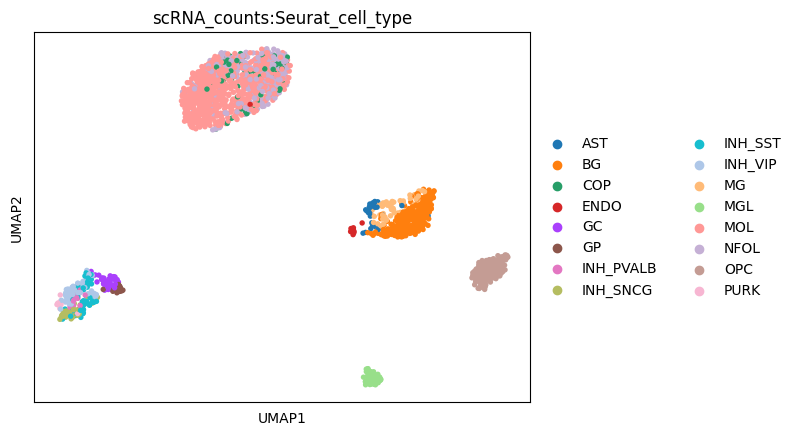

In [12]:
sc.pl.umap(eRegulon_gene_AUC, color = "scRNA_counts:Seurat_cell_type") # LZ

## eRegulon specificity score

In [13]:
from scenicplus.RSS import (regulon_specificity_scores, plot_rss)

In [14]:
rss = regulon_specificity_scores(
    scplus_mudata = scplus_mdata,
    variable = "scRNA_counts:Seurat_cell_type",
    modalities = ["direct_gene_based_AUC", "extended_gene_based_AUC"]
)

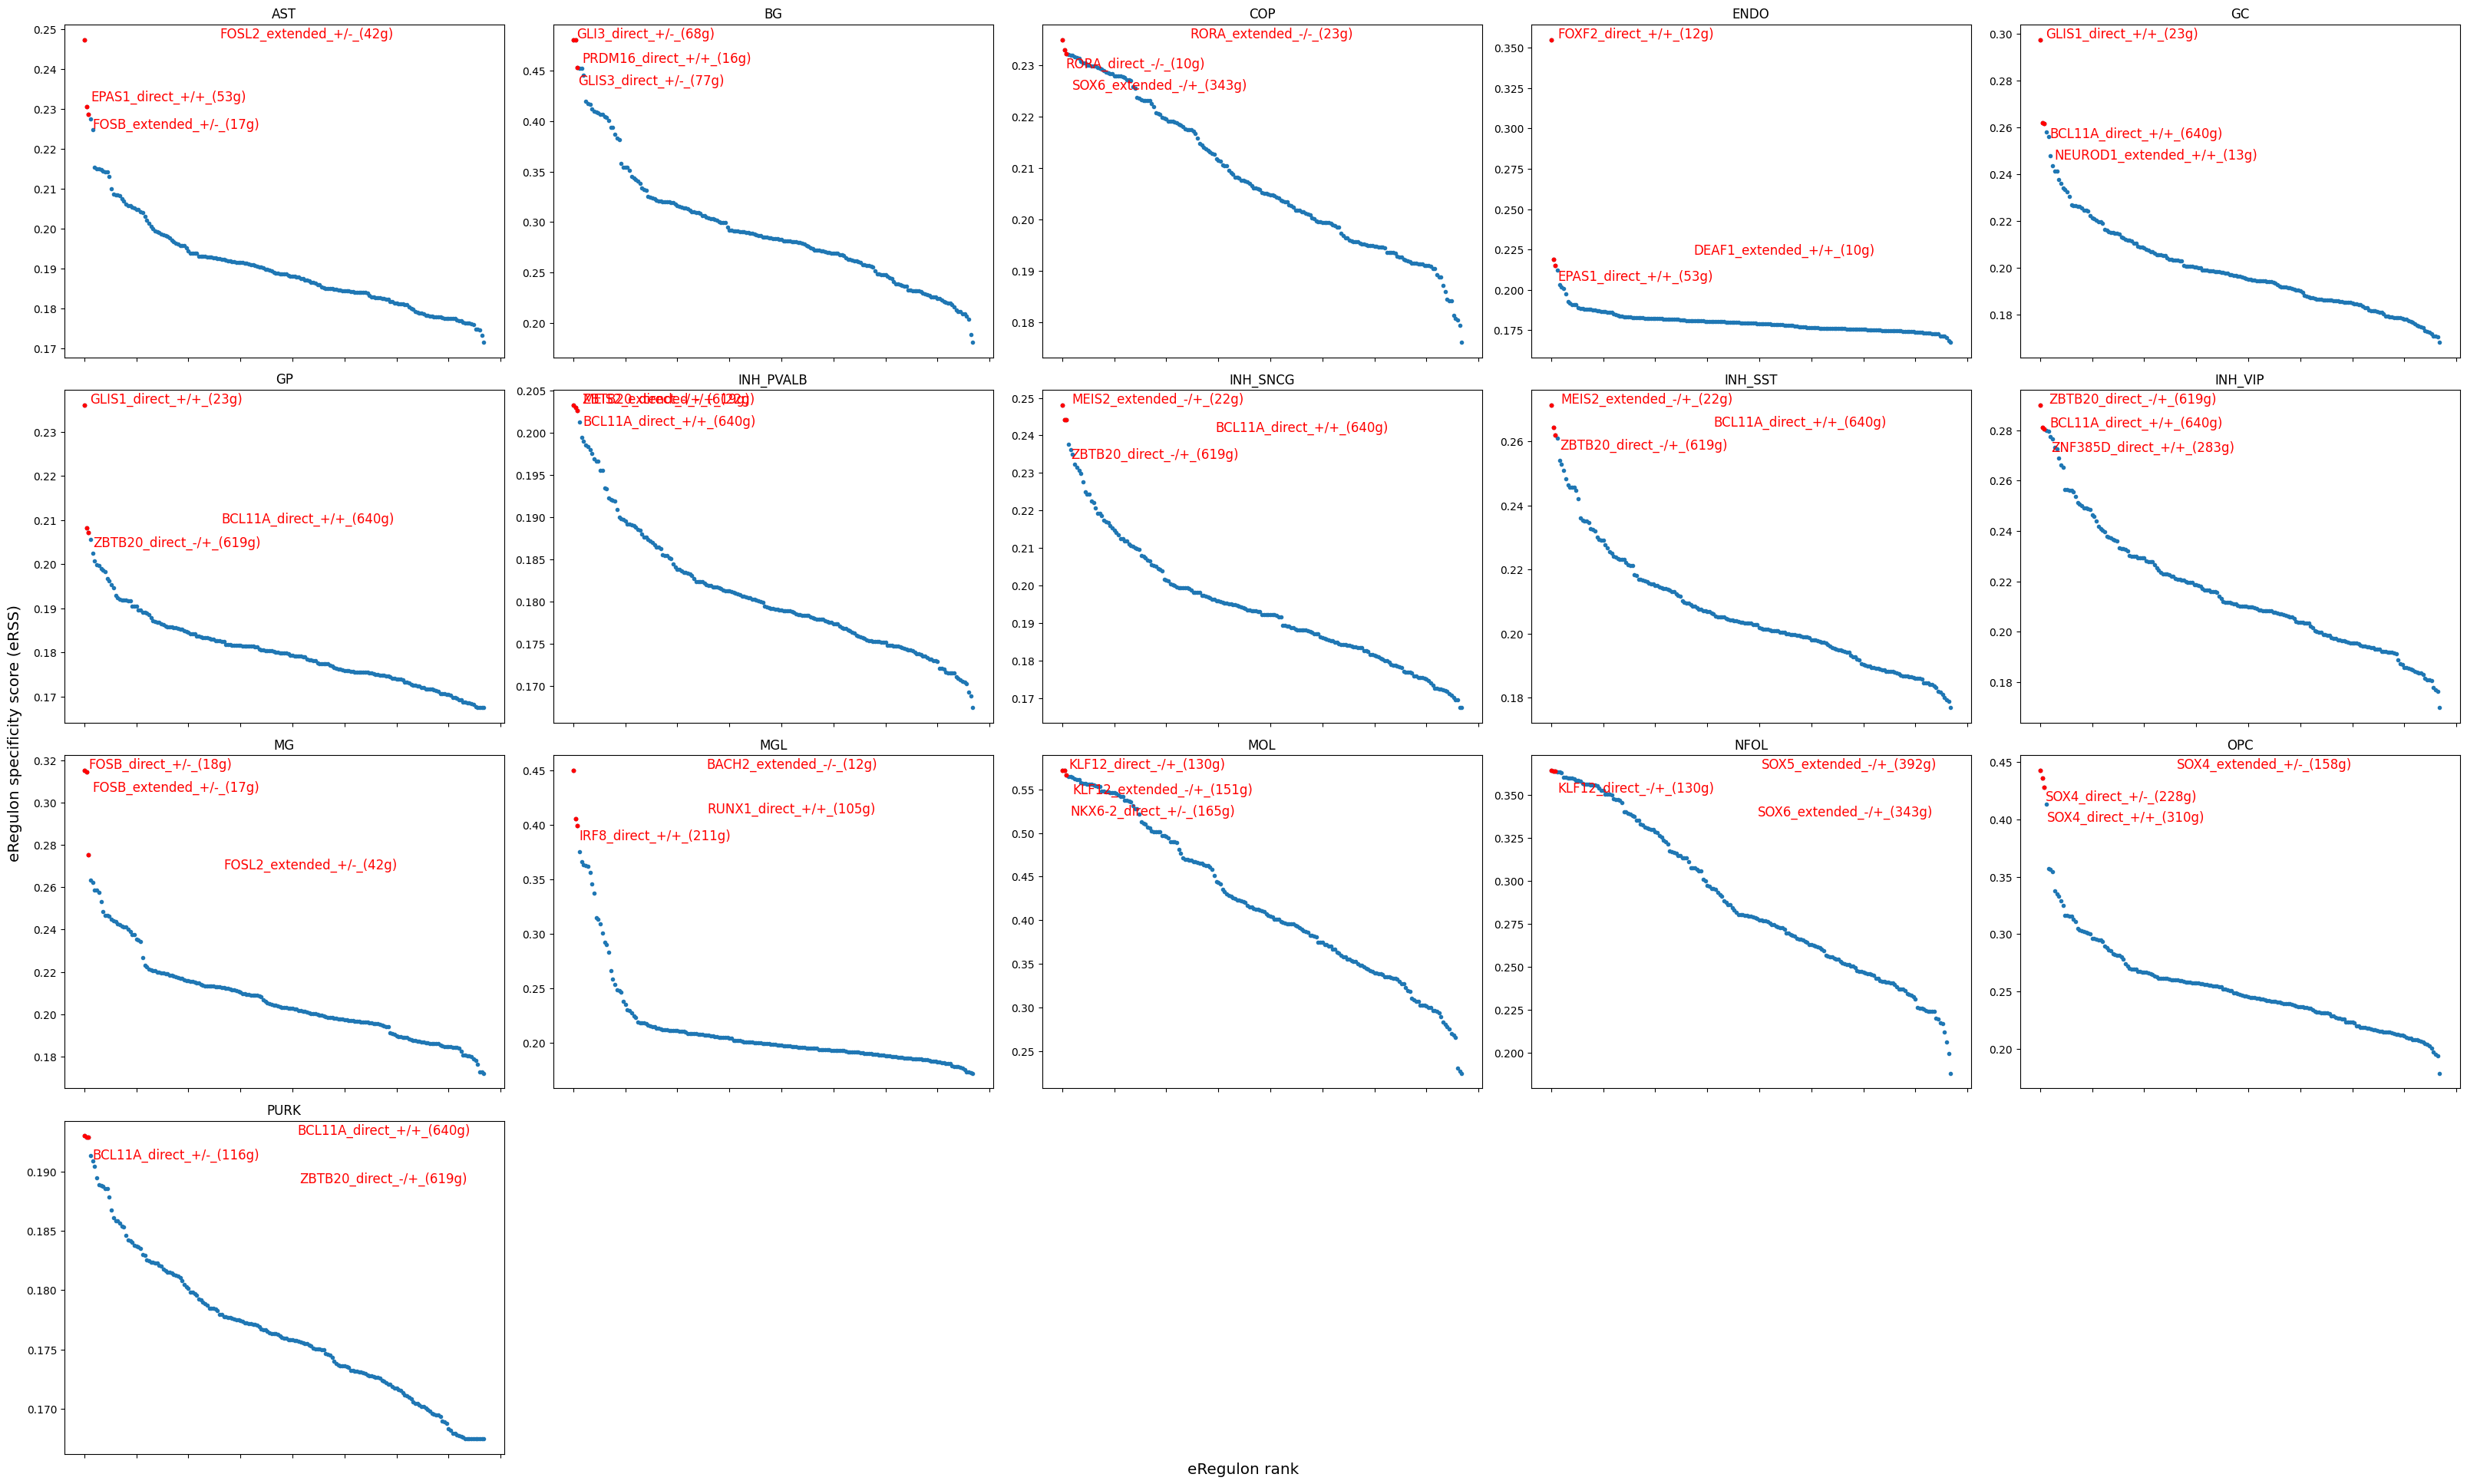

In [15]:
plot_rss(
    data_matrix = rss,
    top_n = 3,
    num_columns = 5
)

## Plot eRegulon enrichment scores

eRegulon enrichment scores can be plotted on the UMAP.

/opt/homebrew/anaconda3/envs/scenicplus/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


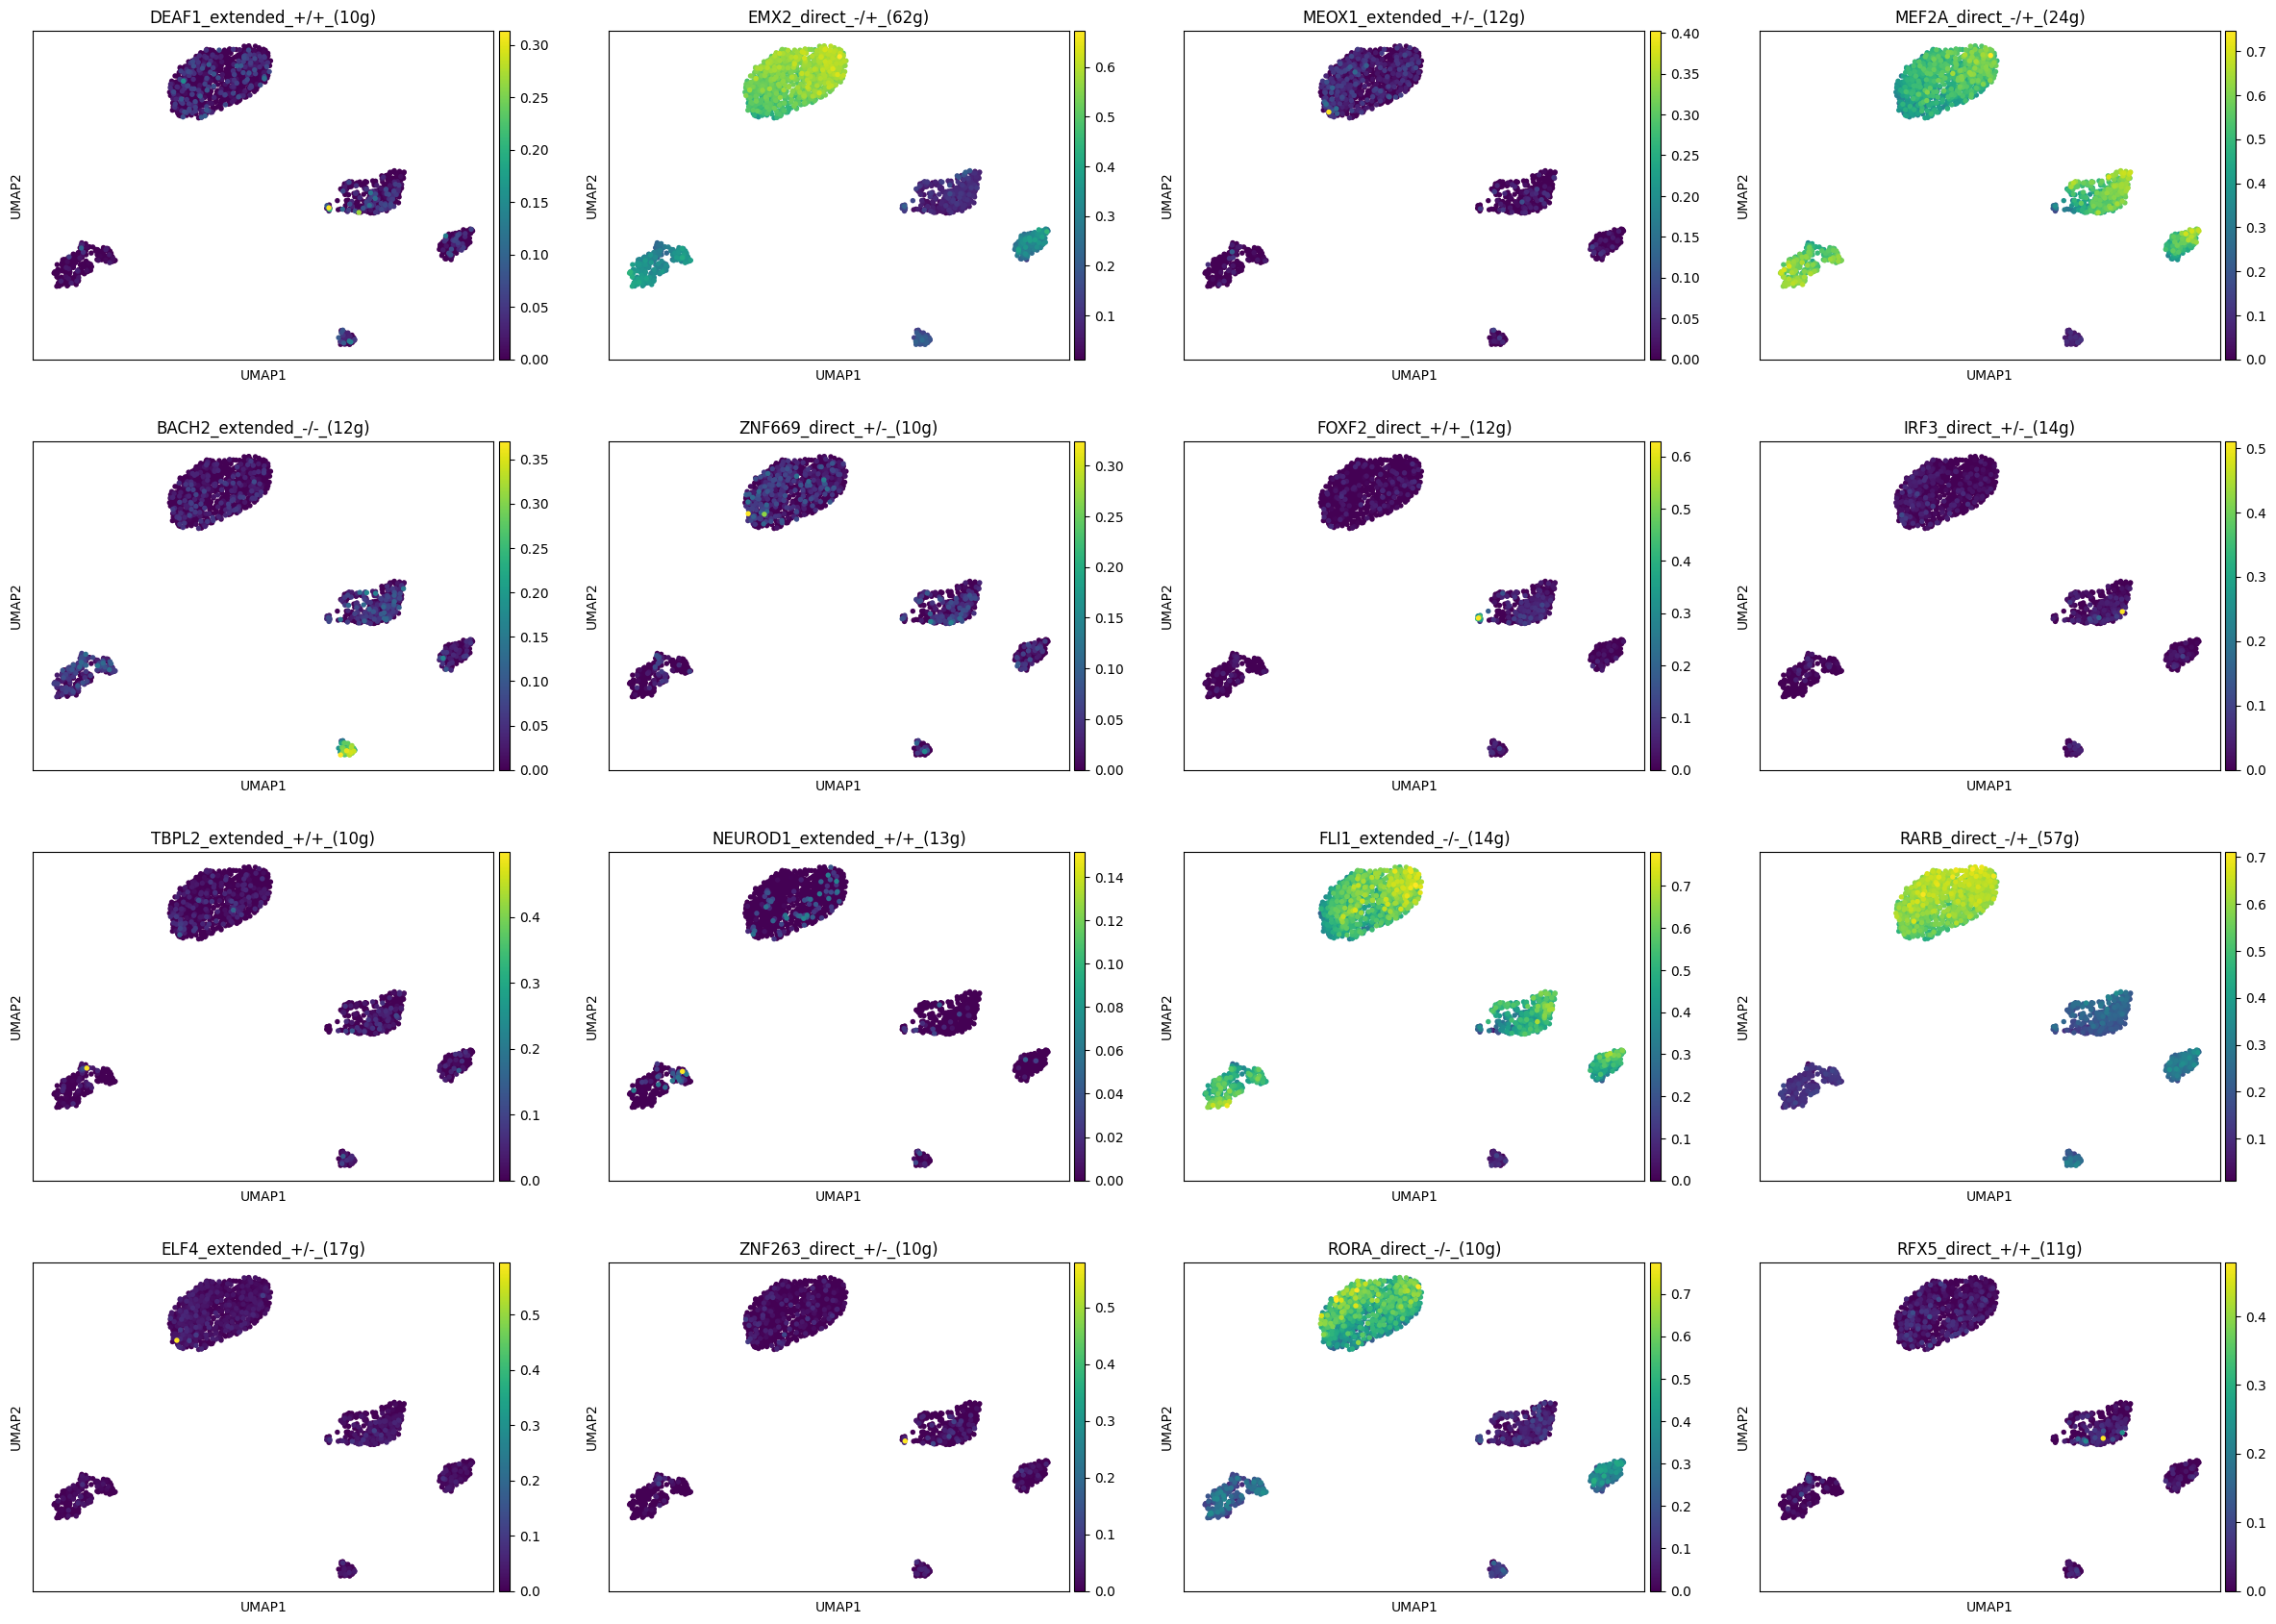

In [16]:
sc.pl.umap(eRegulon_gene_AUC, color = list(set([x for xs in [rss.loc[ct].sort_values()[0:2].index for ct in rss.index] for x in xs ])))

## Heatmap dotplot

We can draw a heatmap where the color represent target gene enrichment and the dotsize target region enrichment.

In [17]:
from scenicplus.plotting.dotplot import heatmap_dotplot

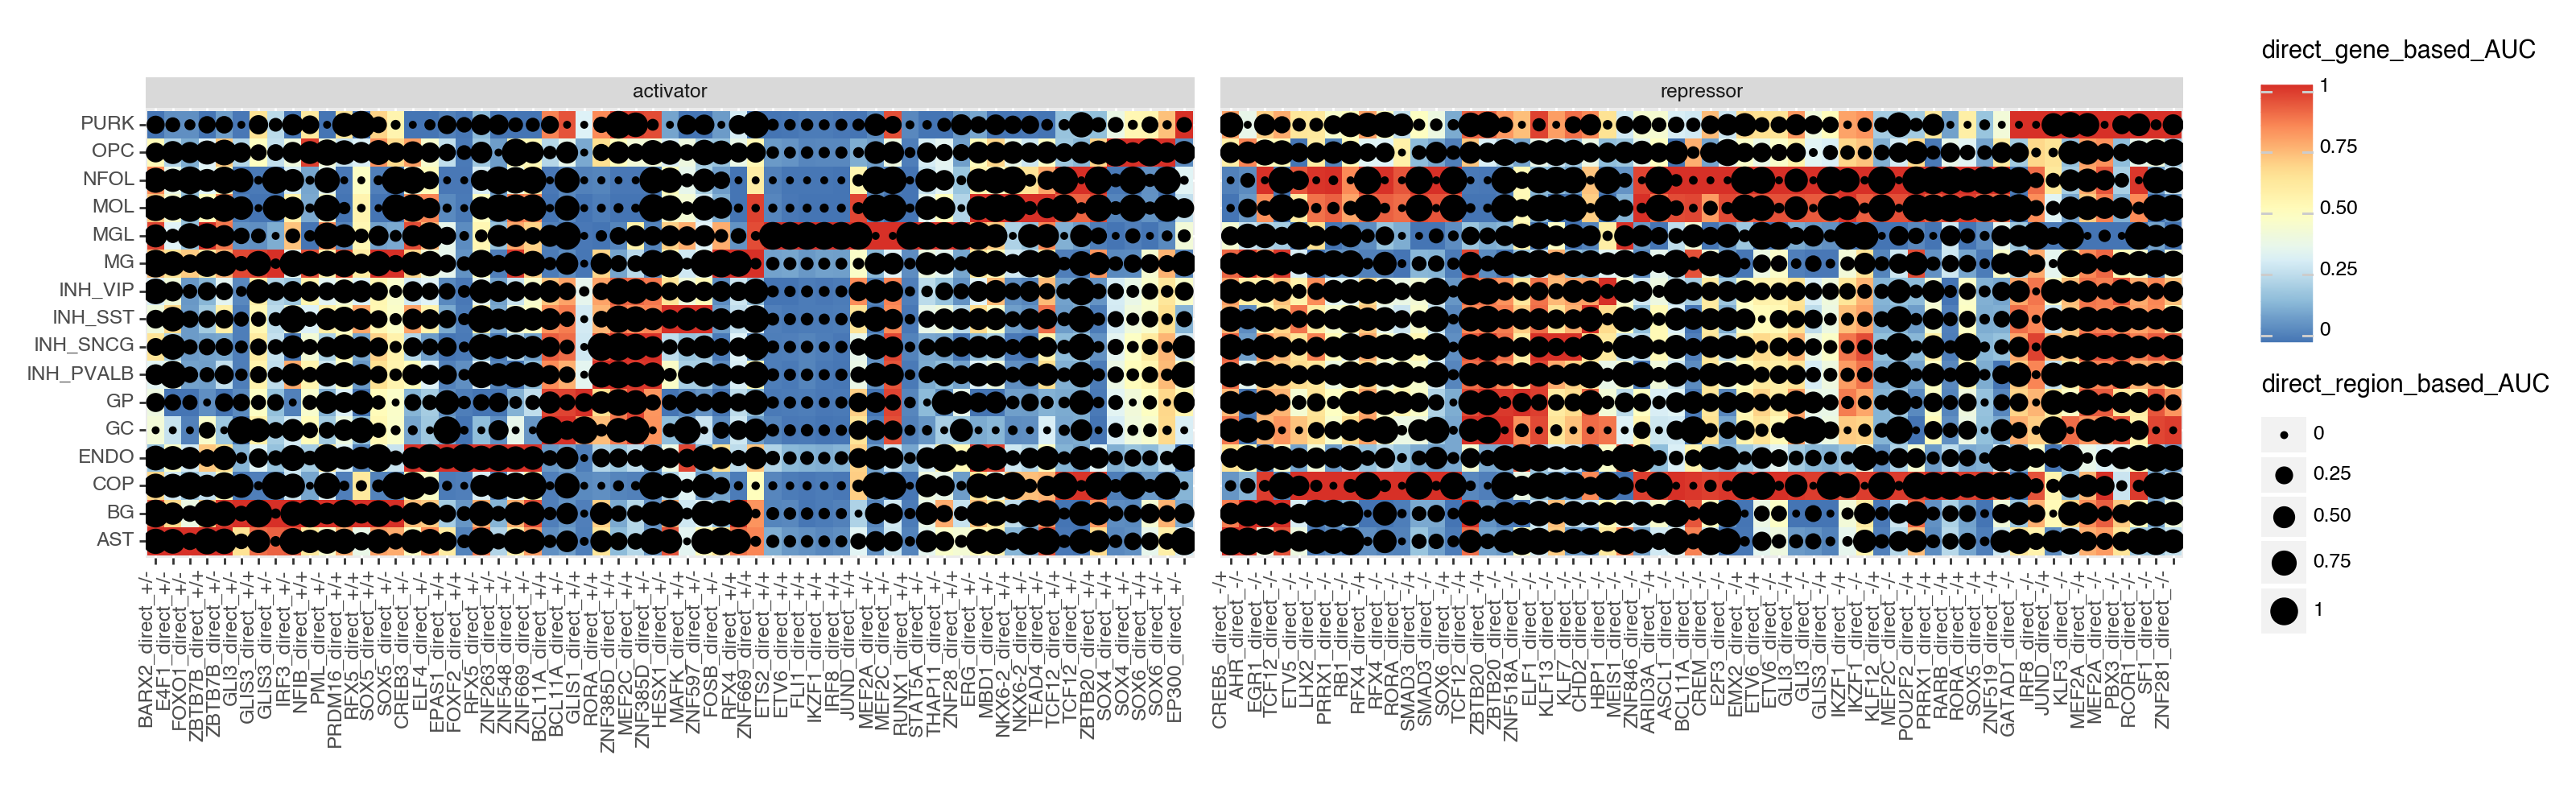

<Figure Size: (1600 x 500)>

In [ ]:
heatmap_dotplot(
    scplus_mudata = scplus_mdata,
    color_modality = "direct_gene_based_AUC",
    size_modality = "direct_region_based_AUC",
    group_variable = "scRNA_counts:Seurat_cell_type",
    eRegulon_metadata_key = "direct_e_regulon_metadata",
    color_feature_key = "Gene_signature_name",
    size_feature_key = "Region_signature_name",
    feature_name_key = "eRegulon_name",
    sort_data_by = "direct_gene_based_AUC",
    orientation = "horizontal",
    figsize = (16, 5)
)